In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
import xgboost as xgb
import sys
sys.path.append("..")
from common_functions import HSV_features_generation

In [3]:
def eval_XGBoost(X,y,k,max_depth,num_rounds,learning_rate=0.3, min_split_loss=0,min_child_weight=1,max_delta_step=0,subsample=1,colsample_bytree=1,show_tree=False):
    # Initialize lists to store the accuracy scores, features weights and confusion matrix
    accuracy_scores = []
    val_accuracy_scores = []
    test_accuracy_scores = []
    confusion_matrixs = []
    val_confusion_matrixs = []
    test_confusion_matrixs = []

    # StratifiedKFold with k folds
    skf = StratifiedKFold(n_splits=k)

    for i, (train_index, val_test_index) in enumerate(skf.split(X, y)):
        if(show_tree):
            print(f"Fold {i}:")
        #Train dataset
        X_train = X.iloc[train_index]
        y_train = y[train_index]

        #Validation and test dataset
        skf2 = StratifiedKFold(n_splits=2)
        test_index,val_index = next(skf2.split(X.iloc[val_test_index], y[val_test_index]))
        X_val = X.iloc[val_test_index].iloc[val_index]
        y_val = y[val_test_index][val_index]
        X_test = X.iloc[val_test_index].iloc[test_index]
        y_test = y[val_test_index][test_index]

        #Decision tree init
        dtrain = xgb.DMatrix(X_train, label=y_train)
        dval = xgb.DMatrix(X_val, label=y_val)
        dtest = xgb.DMatrix(X_test, label=y_test)
        
        # Define XG Boost parameters
        params = {
            'objective': 'multi:softmax',  #Objective multi-class classifcation
            'max_depth': max_depth, 
            'num_class': 3,
            'learning_rate': learning_rate,
            'min_split_loss' : min_split_loss,
            'min_child_weight': min_child_weight,
            'max_delta_step':max_delta_step,
            'subsample':subsample,
            'colsample_bytree':colsample_bytree
        }
        
        model = xgb.train(params, dtrain, num_rounds)

         #Predictions
        y_train_pred = model.predict(dtrain)
        y_val_pred = model.predict(dval)
        y_test_pred = model.predict(dtest)

        #Accuracy score
        accuracy = metrics.accuracy_score(y_train, y_train_pred)
        val_accuracy = metrics.accuracy_score(y_val, y_val_pred)
        test_accuracy = metrics.accuracy_score(y_test, y_test_pred)

        #Confusion matrix
        confusion_mat = confusion_matrix(y_train, y_train_pred)
        confusion_mat_val = confusion_matrix(y_val, y_val_pred)
        confusion_mat_test = confusion_matrix(y_test, y_test_pred)

        if(show_tree):
            print(f'Fold {i} accuracy : {accuracy}, val accuracy :{val_accuracy}, test accuracy : {test_accuracy}')

        #Append the accuracy score to the list
        accuracy_scores.append(accuracy)
        val_accuracy_scores.append(val_accuracy)
        test_accuracy_scores.append(test_accuracy)
        confusion_matrixs.append(confusion_mat)
        val_confusion_matrixs.append(confusion_mat_val)
        test_confusion_matrixs.append(confusion_mat_test)

    # Compute the average accuracy across all folds
    if(show_tree):
        print('-------------------')
        print(f"Train accuracy : {np.mean(accuracy_scores)}")
        print(f"Val accuracy : {np.mean(val_accuracy_scores)}")
        print(f"Test accuracy : {np.mean(test_accuracy_scores)}")

        labels_x=['normal','excess','insufficient']
        labels_y = labels_x
        fig, ax = plt.subplots(figsize=(4, 3))
        ax.set_xlabel('Prédiction')
        ax.set_ylabel('Vraie étiquette')
        ax.set_title('Matrice de confusion')
        print('Average confusion matrix')
        sns.heatmap(np.mean(confusion_matrixs, axis=0), annot=True, cmap="Blues", ax=ax, fmt='.0f', xticklabels=labels_x, yticklabels=labels_y)
        plt.show()

        fig, ax = plt.subplots(figsize=(4, 3))
        ax.set_xlabel('Prédiction')
        ax.set_ylabel('Vraie étiquette')
        ax.set_title('Matrice de confusion val')
        print('Average val confusion matrix')
        sns.heatmap(np.mean(val_confusion_matrixs, axis=0), annot=True, cmap="Oranges", ax=ax, fmt='.0f', xticklabels=labels_x, yticklabels=labels_y)
        plt.show()

        fig, ax = plt.subplots(figsize=(4, 3))
        ax.set_xlabel('Prédiction')
        ax.set_ylabel('Vraie étiquette')
        ax.set_title('Matrice de confusion test')
        print('Average test confusion matrix')
        sns.heatmap(np.mean(test_confusion_matrixs, axis=0), annot=True, cmap="Greens", ax=ax, fmt='.0f', xticklabels=labels_x, yticklabels=labels_y)
        plt.show()


    return np.mean(accuracy_scores),np.mean(val_accuracy_scores),np.mean(test_accuracy_scores)



In [5]:
#Generation data
X,y = HSV_features_generation('../images/raw_pollub/')


In [146]:
#Test GROUPE 1
k=5
tests_max_depth=range(2,6+1) #2 à 6
num_rounds=100
learning_rate=0.3
min_split_loss=0
tests_min_child_weight=np.arange(0,4.01,0.5) #0 à 4
max_delta_step=0
subsample=1
colsample_bytree=1

acc_train = []
acc_val = []
acc_test = []

for min_child_weight in tests_min_child_weight:
    accuracies = []
    val_accuracies = []
    test_accuracies = []
    for max_depth in tests_max_depth:
        accuracy,val_accuracy,test_accuracy = eval_XGBoost(X,y,k=k,max_depth=max_depth,num_rounds=num_rounds,learning_rate=learning_rate, min_split_loss=min_split_loss,min_child_weight=min_child_weight,max_delta_step=max_delta_step,subsample=subsample,colsample_bytree=colsample_bytree,show_tree=False)
        accuracies.append(accuracy)
        val_accuracies.append(val_accuracy)
        test_accuracies.append(test_accuracy)
    acc_train.append(accuracies)
    acc_val.append(val_accuracies)
    acc_test.append(test_accuracies)


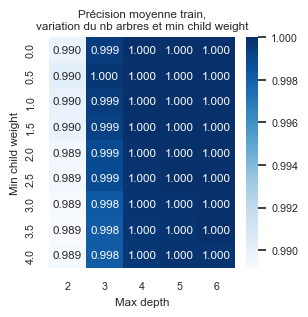

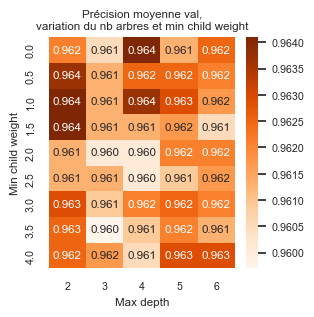

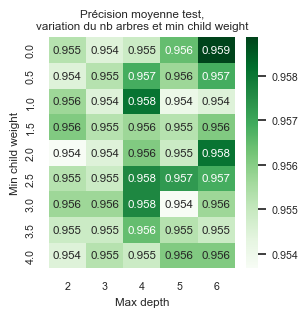

In [109]:
sns.set(font_scale=0.7)
mat_acc_train = np.array(acc_train)
labels_x = tests_max_depth
labels_y = tests_min_child_weight
plt.figure(figsize = (3,3))
sns.heatmap(mat_acc_train, annot=True, cmap="Blues", fmt='.3f', xticklabels=labels_x, yticklabels=labels_y)
plt.xlabel('Max depth')
plt.ylabel('Min child weight')
plt.title('Précision moyenne train,\nvariation du nb arbres et min child weight')
plt.show()

mat_acc_val = np.array(acc_val)
plt.figure(figsize = (3,3))
sns.heatmap(mat_acc_val, annot=True, cmap="Oranges", fmt='.3f', xticklabels=labels_x, yticklabels=labels_y)
plt.xlabel('Max depth')
plt.ylabel('Min child weight')
plt.title('Précision moyenne val,\nvariation du nb arbres et min child weight')
plt.show()

mat_acc_test = np.array(acc_test)
plt.figure(figsize = (3,3))
sns.heatmap(mat_acc_test, annot=True, cmap="Greens", fmt='.3f', xticklabels=labels_x, yticklabels=labels_y)
plt.xlabel('Max depth')
plt.ylabel('Min child weight')
plt.title('Précision moyenne test,\nvariation du nb arbres et min child weight')
plt.show()

In [151]:
#Test GROUPE 2
k=5
max_depth=6
num_rounds=100
learning_rate=0.3
min_split_loss=0
min_child_weight=0
max_delta_step=0
tests_subsample=np.arange(0.5,1.01,0.1) #0.5 à 1
tests_colsample_bytree=np.arange(0.5,1.01,0.1) #0.5 à 1

acc_train = []
acc_val = []
acc_test = []

for subsample in tests_subsample:
    accuracies = []
    val_accuracies = []
    test_accuracies = []
    for colsample_bytree in tests_colsample_bytree:
        accuracy,val_accuracy,test_accuracy = eval_XGBoost(X,y,k=k,max_depth=max_depth,num_rounds=num_rounds,learning_rate=learning_rate, min_split_loss=min_split_loss,min_child_weight=min_child_weight,max_delta_step=max_delta_step,subsample=subsample,colsample_bytree=colsample_bytree,show_tree=False)
        accuracies.append(accuracy)
        val_accuracies.append(val_accuracy)
        test_accuracies.append(test_accuracy)
    acc_train.append(accuracies)
    acc_val.append(val_accuracies)
    acc_test.append(test_accuracies)

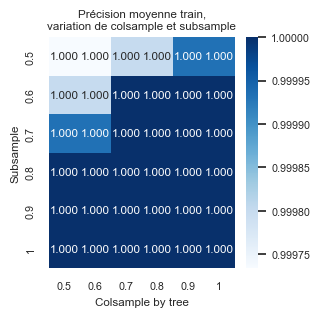

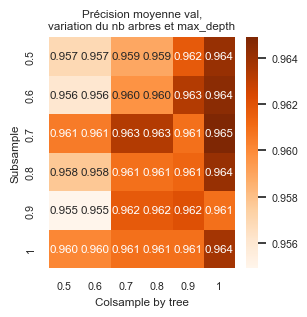

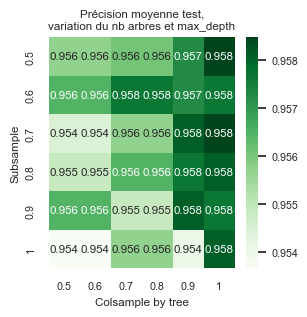

In [113]:
import seaborn as sns
sns.set(font_scale=0.7)
mat_acc_train = np.array(acc_train)
labels_x = [0.5,0.6,0.7,0.8,0.9,1]
labels_y = [0.5,0.6,0.7,0.8,0.9,1]
plt.figure(figsize = (3,3))
sns.heatmap(mat_acc_train, annot=True, cmap="Blues", fmt='.3f', xticklabels=labels_x, yticklabels=labels_y)
plt.xlabel('Colsample by tree')
plt.ylabel('Subsample')
plt.title('Précision moyenne train,\nvariation de colsample et subsample')
plt.show()

mat_acc_val = np.array(acc_val)
plt.figure(figsize = (3,3))
sns.heatmap(mat_acc_val, annot=True, cmap="Oranges", fmt='.3f', xticklabels=labels_x, yticklabels=labels_y)
plt.xlabel('Colsample by tree')
plt.ylabel('Subsample')
plt.title('Précision moyenne val,\nvariation du nb arbres et max_depth')
plt.show()

mat_acc_test = np.array(acc_test)
plt.figure(figsize = (3,3))
sns.heatmap(mat_acc_test, annot=True, cmap="Greens", fmt='.3f', xticklabels=labels_x, yticklabels=labels_y)
plt.xlabel('Colsample by tree')
plt.ylabel('Subsample')
plt.title('Précision moyenne test,\nvariation du nb arbres et max_depth')
plt.show()

In [152]:
#Test GROUPE 3
k=5
max_depth=6
tests_num_rounds=np.arange(100,1001,200)
tests_learning_rate=np.arange(0.1,1.01,0.2)
num_rounds=100
learning_rate=0.3
min_split_loss=0
min_child_weight=0
max_delta_step=0
subsample=0.7
tests_colsample_bytree=1

acc_train = []
acc_val = []
acc_test = []

for num_rounds in tests_num_rounds:
    accuracies = []
    val_accuracies = []
    test_accuracies = []
    for learning_rate in tests_learning_rate:
        accuracy,val_accuracy,test_accuracy = eval_XGBoost(X,y,k=k,max_depth=max_depth,num_rounds=num_rounds,learning_rate=learning_rate, min_split_loss=min_split_loss,min_child_weight=min_child_weight,max_delta_step=max_delta_step,subsample=subsample,colsample_bytree=colsample_bytree,show_tree=False)
        accuracies.append(accuracy)
        val_accuracies.append(val_accuracy)
        test_accuracies.append(test_accuracy)
    acc_train.append(accuracies)
    acc_val.append(val_accuracies)
    acc_test.append(test_accuracies)

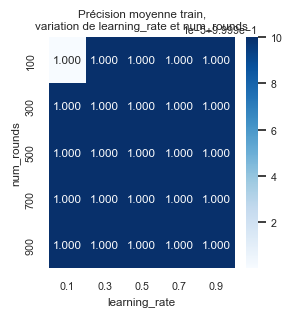

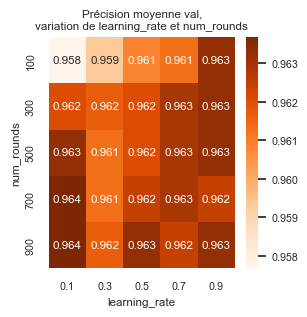

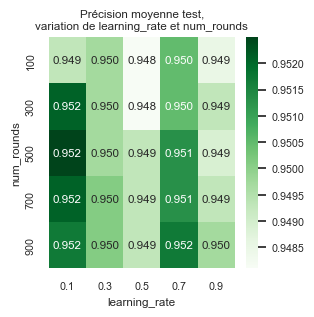

In [153]:
sns.set(font_scale=0.7)
mat_acc_train = np.array(acc_train)
labels_x = [0.1,0.3,0.5,0.7,0.9]
labels_y = [100,300,500,700,900]
plt.figure(figsize = (3,3))
sns.heatmap(mat_acc_train, annot=True, cmap="Blues", fmt='.3f', xticklabels=labels_x, yticklabels=labels_y)
plt.xlabel('learning_rate')
plt.ylabel('num_rounds')
plt.title('Précision moyenne train,\nvariation de learning_rate et num_rounds')
plt.show()

mat_acc_val = np.array(acc_val)
plt.figure(figsize = (3,3))
sns.heatmap(mat_acc_val, annot=True, cmap="Oranges", fmt='.3f', xticklabels=labels_x, yticklabels=labels_y)
plt.xlabel('learning_rate')
plt.ylabel('num_rounds')
plt.title('Précision moyenne val,\nvariation de learning_rate et num_rounds')
plt.show()

mat_acc_test = np.array(acc_test)
plt.figure(figsize = (3,3))
sns.heatmap(mat_acc_test, annot=True, cmap="Greens", fmt='.3f', xticklabels=labels_x, yticklabels=labels_y)
plt.xlabel('learning_rate')
plt.ylabel('num_rounds')
plt.title('Précision moyenne test,\nvariation de learning_rate et num_rounds')
plt.show()

In [6]:
#Test GROUPE 4
k=5
max_depth=6
num_rounds=500
learning_rate=0.1
tests_min_split_loss=range(0,5+1)
min_child_weight=0
tests_max_delta_step=range(0,5+1)
subsample=0.7
colsample_bytree=1

acc_train = []
acc_val = []
acc_test = []

for min_split_loss in tests_min_split_loss:
    accuracies = []
    val_accuracies = []
    test_accuracies = []
    for max_delta_step in tests_max_delta_step:
        accuracy,val_accuracy,test_accuracy = eval_XGBoost(X,y,k=k,max_depth=max_depth,num_rounds=num_rounds,learning_rate=learning_rate, min_split_loss=min_split_loss,min_child_weight=min_child_weight,max_delta_step=max_delta_step,subsample=subsample,colsample_bytree=colsample_bytree,show_tree=False)
        accuracies.append(accuracy)
        val_accuracies.append(val_accuracy)
        test_accuracies.append(test_accuracy)
    acc_train.append(accuracies)
    acc_val.append(val_accuracies)
    acc_test.append(test_accuracies)

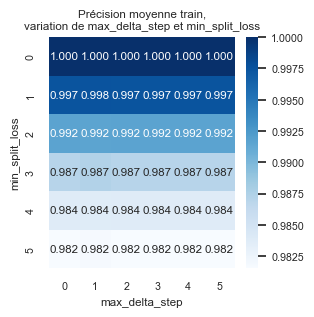

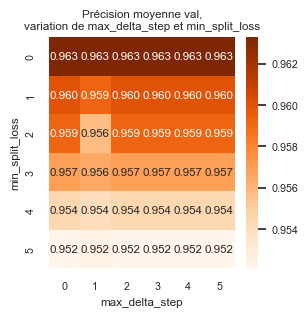

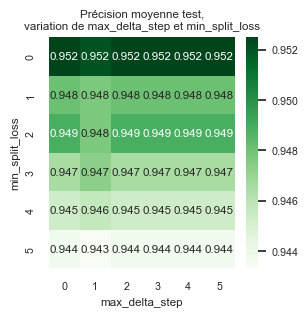

In [158]:
sns.set(font_scale=0.7)
mat_acc_train = np.array(acc_train)
labels_x = tests_max_delta_step
labels_y = tests_min_split_loss
plt.figure(figsize = (3,3))
sns.heatmap(mat_acc_train, annot=True, cmap="Blues", fmt='.3f', xticklabels=labels_x, yticklabels=labels_y)
plt.xlabel('max_delta_step')
plt.ylabel('min_split_loss')
plt.title('Précision moyenne train,\nvariation de max_delta_step et min_split_loss')
plt.show()

mat_acc_val = np.array(acc_val)
plt.figure(figsize = (3,3))
sns.heatmap(mat_acc_val, annot=True, cmap="Oranges", fmt='.3f', xticklabels=labels_x, yticklabels=labels_y)
plt.xlabel('max_delta_step')
plt.ylabel('min_split_loss')
plt.title('Précision moyenne val,\nvariation de max_delta_step et min_split_loss')
plt.show()

mat_acc_test = np.array(acc_test)
plt.figure(figsize = (3,3))
sns.heatmap(mat_acc_test, annot=True, cmap="Greens", fmt='.3f', xticklabels=labels_x, yticklabels=labels_y)
plt.xlabel('max_delta_step')
plt.ylabel('min_split_loss')
plt.title('Précision moyenne test,\nvariation de max_delta_step et min_split_loss')
plt.show()

Fold 0:
Fold 0 accuracy : 1.0, val accuracy :0.9505582137161085, test accuracy : 0.9792332268370607
Fold 1:
Fold 1 accuracy : 1.0, val accuracy :0.9617224880382775, test accuracy : 0.9712460063897763
Fold 2:
Fold 2 accuracy : 1.0, val accuracy :0.9760383386581469, test accuracy : 0.9313099041533547
Fold 3:
Fold 3 accuracy : 1.0, val accuracy :0.9696485623003195, test accuracy : 0.9568690095846646
-------------------
Train accuracy : 1.0
Val accuracy : 0.9644919006782131
Test accuracy : 0.959664536741214
Average confusion matrix


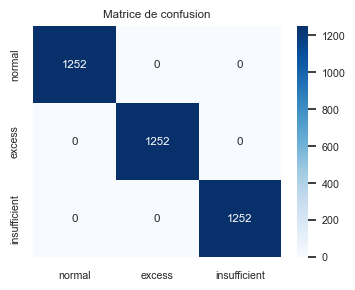

Average val confusion matrix


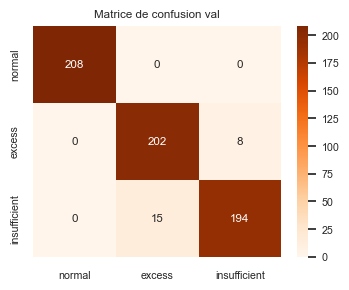

Average test confusion matrix


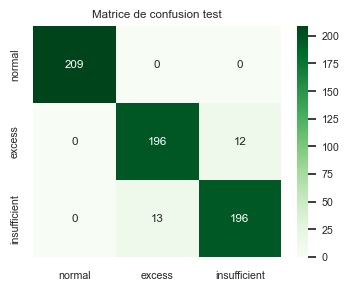

In [150]:
accuracy,val_accuracy,test_accuracy = eval_XGBoost(X,y,k=4,max_depth=4,num_rounds=100,learning_rate=0.5, min_split_loss=0,min_child_weight=1,max_delta_step=0,subsample=0.7,colsample_bytree=1,show_tree=True)

In [163]:
#ROI
X,y = HSV_features_generation('../images/ROI_pollub/')

In [164]:
eval_XGBoost(X,y,k=4,max_depth=4,num_rounds=100,learning_rate=0.5, min_split_loss=0,min_child_weight=1,max_delta_step=0,subsample=0.7,colsample_bytree=1)

(0.9978708185380549, 0.8571300273629179, 0.8087060702875399)

In [165]:
eval_XGBoost(X,y,k=5,max_depth=6,num_rounds=500,learning_rate=0.1, min_split_loss=0,min_child_weight=0,max_delta_step=0,subsample=0.7,colsample_bytree=1)

(1.0, 0.8235528942115768, 0.8415169660678643)